# BioWatch - Un sistema di monitoraggio in real-time di parametri vitali

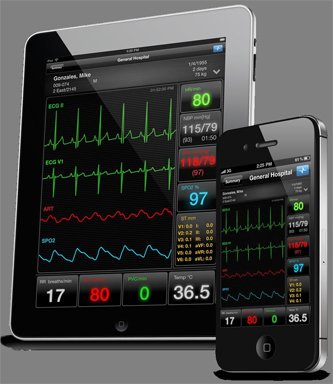

**BioWatch** è un sistema di monitoraggio dei parametri vitali dei pazienti, progettato per supportare il personale sanitario nella gestione dei pazienti a distanza, attraverso la raccolta, l'elaborazione e la visualizzazione in tempo reale dei dati vitali. 

# Obiettivi del progetto

# Monitoraggio continuo e remoto
Tradizionalmente, i pazienti che necessitano di un monitoraggio continuo dei parametri vitali sono **connessi a dispositivi di monitoraggio fissi**, che permettono agli operatori sanitari di avere accesso in tempo reale ai dati vitali del paziente, mentre il paziente rimane sotto osservazione costante. Questo tipo di monitoraggio è ovviamente fondamentale per pazienti in condizioni critiche. Tuttavia, esistono anche pazienti con condizioni di salute meno critiche, che potrebbero beneficiare di un monitoraggio costante, **ma senza necessità di una presenza costante in ospedale**. 

# Accessibilità remota per i medici 
L'accesso remoto ai dati vitali dei pazienti consente ai medici di monitorare in tempo reale i parametri vitali senza la necessità di essere fisicamente presenti al letto del paziente.
Utilizzando dispositivi mobili (smartphone, tablet) o piattaforme cloud, i medici possono accedere a queste informazioni ovunque si trovino, sia che siano in ospedale, a casa o in un altro luogo. Questo significa che **la cura del paziente non dipende più dalla presenza fisica del medico, ma dalla disponibilità dei dati in tempo reale**.

# Miglioramento della qualità di vita dei pazienti
La possibilità di essere monitorati da remoto, senza la necessità di recarsi continuamente in ospedale o in clinica, migliora la qualità della vita dei pazienti. I pazienti non devono affrontare lunghe attese o spostamenti, specialmente quelli che vivono lontano da strutture sanitarie, e possono continuare la loro vita quotidiana in modo più sereno, senza lo stress e l'ansia che possono derivare dalle visite ospedaliere frequenti.

# Allarmi intelligenti e predittivi
Grazie all’integrazione con modelli di AI, il sistema non si limita a segnalare alterazioni dei parametri vitali, ma è in grado di analizzare i dati **in modo predittivo**, identificando schemi che potrebbero indicare un peggioramento prima che diventi critico. Per esempio, nel caso di un paziente con insufficienza cardiaca, la pressione sanguigna e la frequenza cardiaca potrebbero iniziare a mostrare una tendenza a peggiorare in modo graduale, anche se i valori non sono ancora abbastanza alti da generare un allarme immediato. Un sistema basato su AI sarebbe in grado di anticipare questa progressione e inviare un avviso prima che il problema si trasformi in una crisi.

# Ottimizzazione delle risorse ospedaliere
Poiché non è necessario che il paziente sia sempre ricoverato, il sistema riduce la pressione sulle strutture ospedaliere e sulle risorse sanitarie. I pazienti che non necessitano di ricovero possono essere monitorati a distanza, lasciando spazio nei reparti ospedalieri per chi è realmente in condizioni critiche.

# Data pipeline

L'architettura del sistema è costruita usando tecnologie avanzate, tutte containerizzate tramite **Docker** per garantire portabilità e facilità di distribuzione.

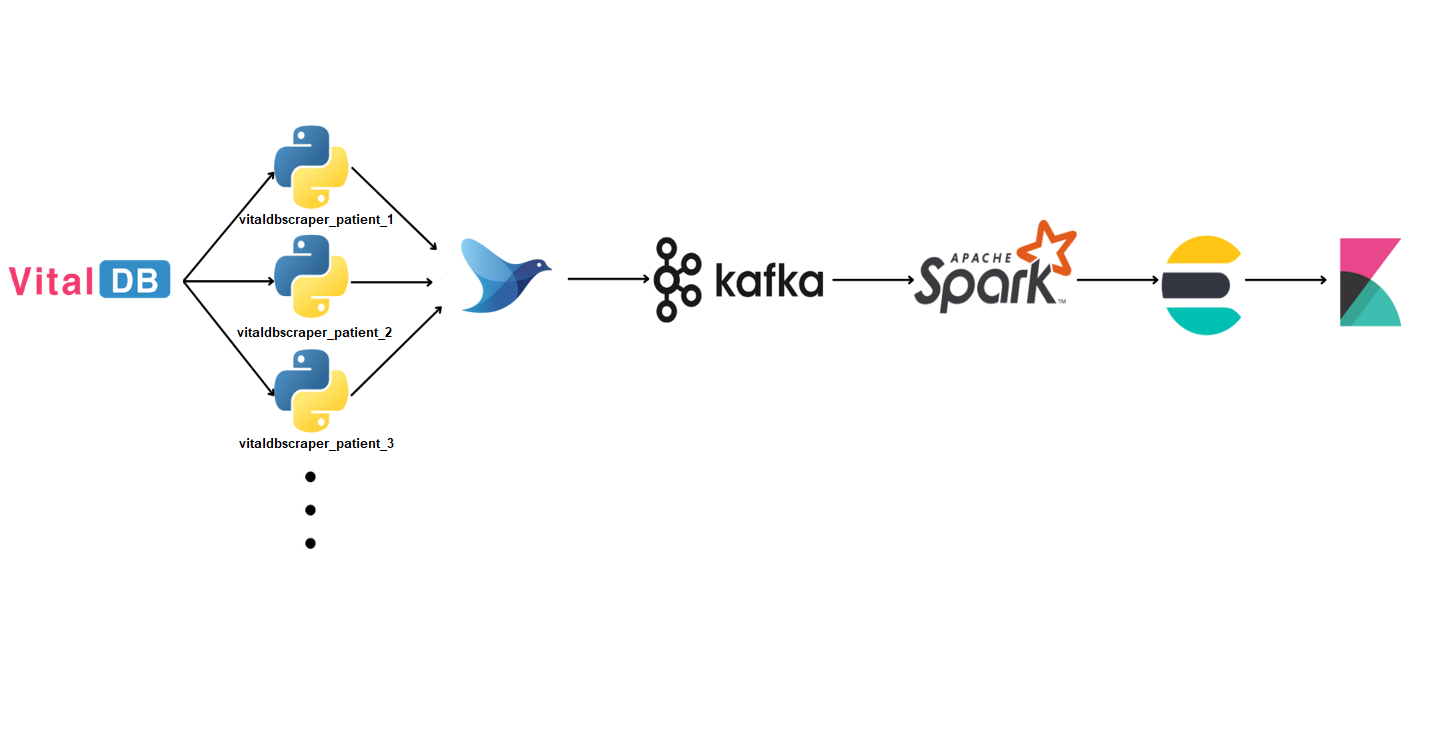

# Data Ingestion

# Come possiamo simulare i parametri vitali?

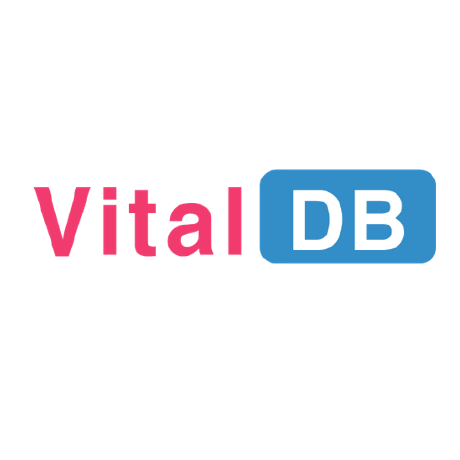

# Cos'è VitalDB?
E' un dataset di **6.388 pazienti** composto da **biosegnali intraoperatori** e **informazioni cliniche**. I dati dei biosegnali inclusi nel dataset sono di alta qualità, con segnali in forma d'onda a **500 Hz** e valori numerici registrati a intervalli compresi **tra 1 e 7 secondi**. Sono inoltre fornite oltre **60 informazioni cliniche relative all'intervento chirurgico**.

# Diamogli un'occhiata...

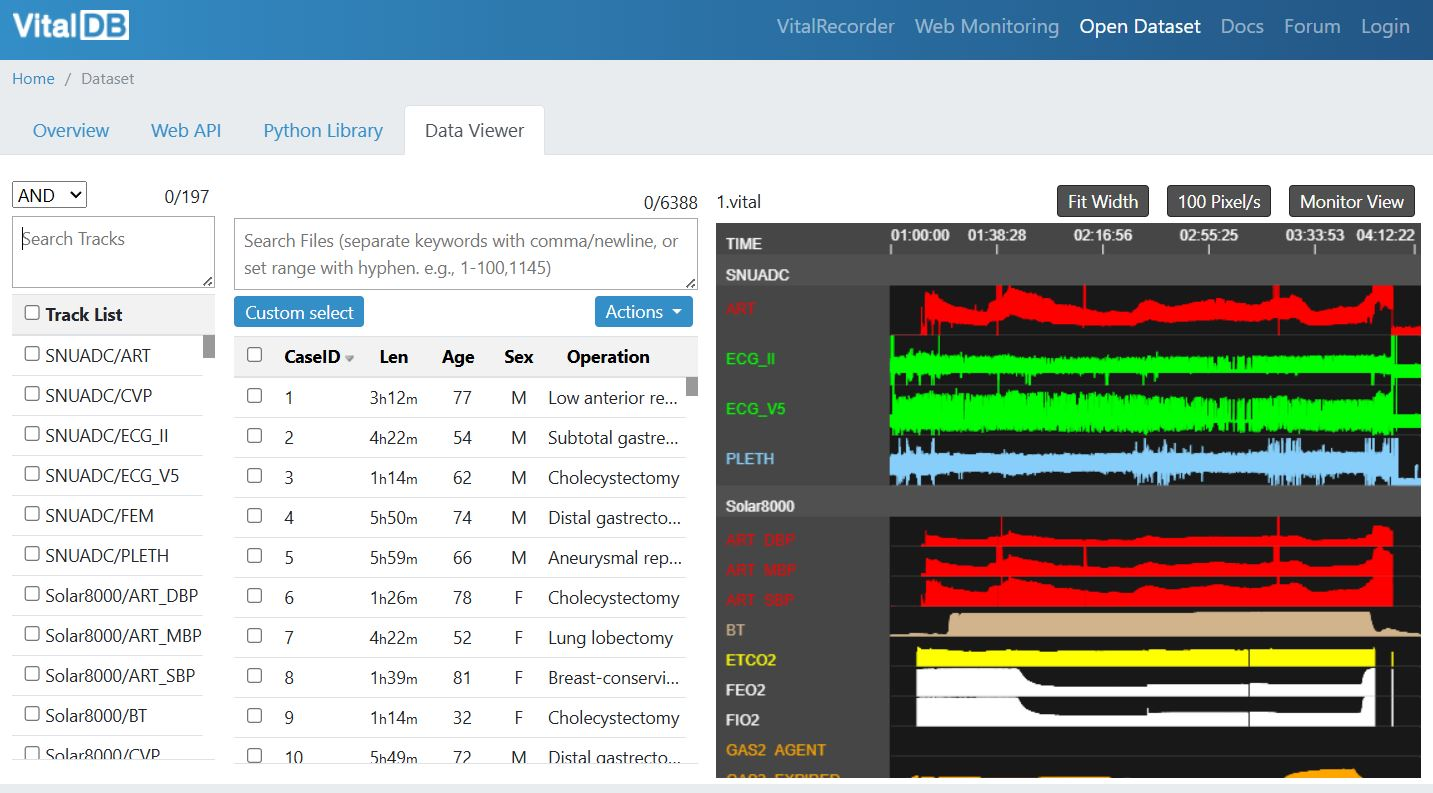

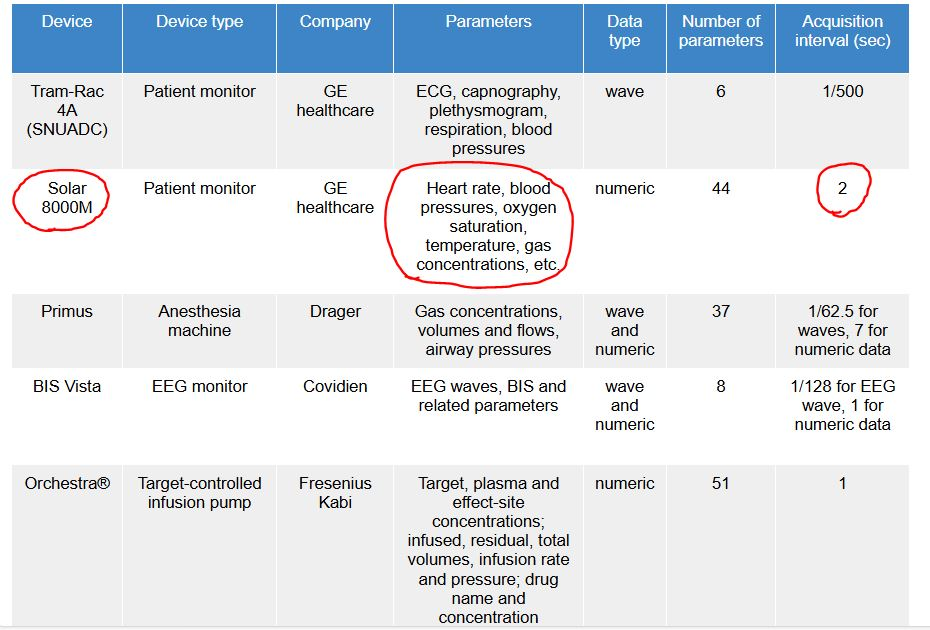

# Come funziona VitalDBScraper?

- Recupera **i dati clinici del paziente** (età, sesso, altezza, peso) tramite VitalDB Web API 
- Recupera i dati relativi ai **parametri vitali** del paziente acquisiti tramite il dispositivo Solar 8000M (Heart Rate, Respiratory Rate, Oxygen Saturation, Body Temperature, Systolic Blood Pressure, Diastolic Blood Pressure). Per fare questo si sfrutta la libreria Python vitaldb
- Dato che il monitor multiparametrico Solar 8000M acquisisce i dati vitali ogni 2 secondi, la simulazione mantiene questa frequenza di campionamento inviando i dati a Fluentd **ogni 2 secondi**. Il timestamp viene aggiornato dinamicamente per allineare i dati all'orario corrente, replicando fedelmente il comportamento di un dispositivo reale.


# Ma analizziamo i primi record...
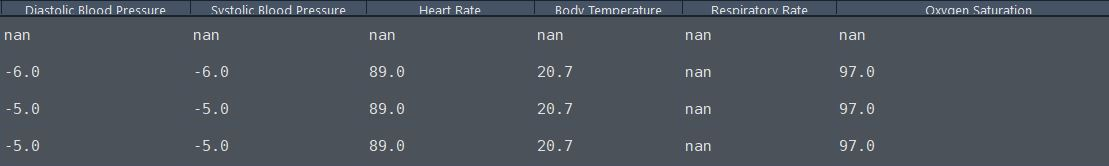

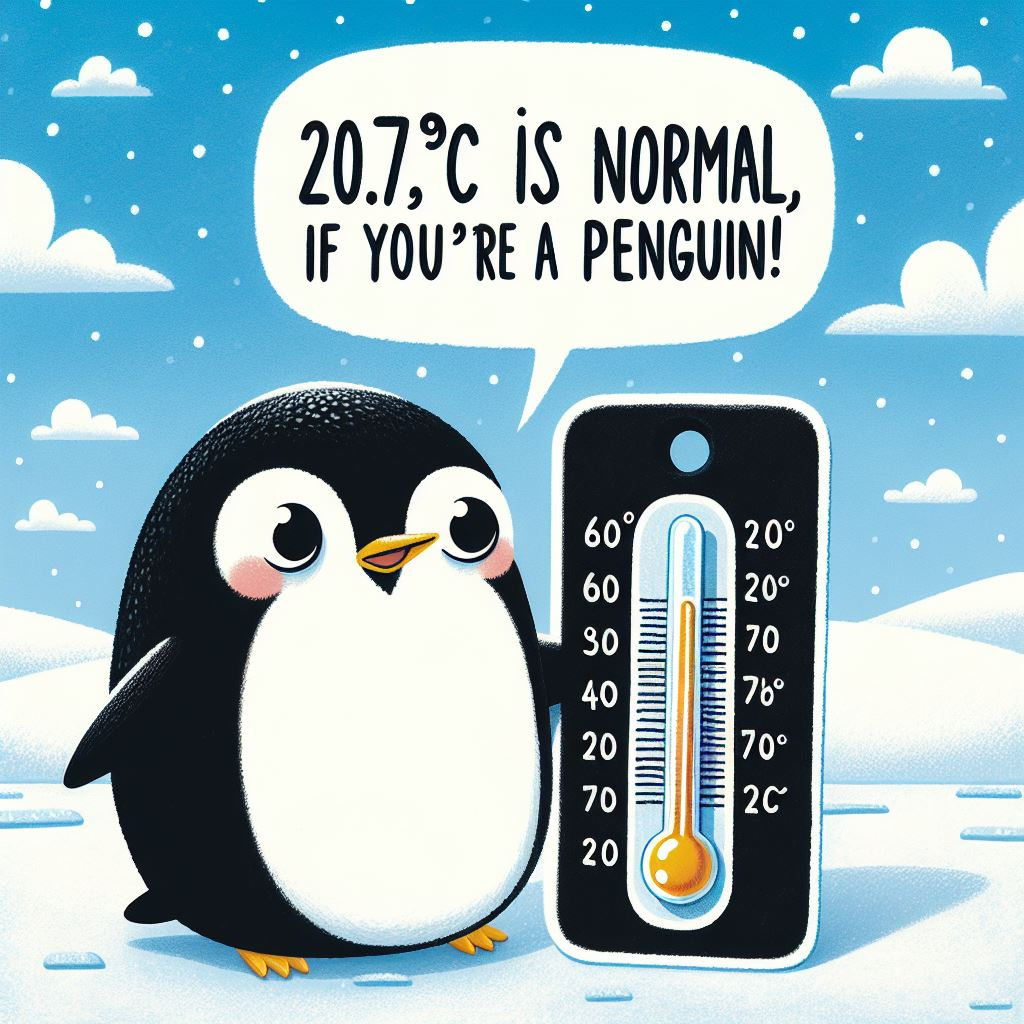

- Il 25% dei dati iniziali e il 25% dei dati finali vengono eliminati, lasciando soltanto la metà centrale dei dati, corrispondente allo **scarto interquartile (IQR)**. In altre parole, viene conservato il 50% dei dati compreso tra il primo e il terzo quartile, che rappresenta l’intervallo più significativo e meno soggetto all’influenza di valori anomali o estremi.


I dati vengono inviati a Fluentd tramite **HTTP**, utilizzando richieste POST. Fluentd riceve questi dati e li inoltra a **Kafka**, scrivendoli sul topic **vitaldb**.











# Data Streaming: Kafka 

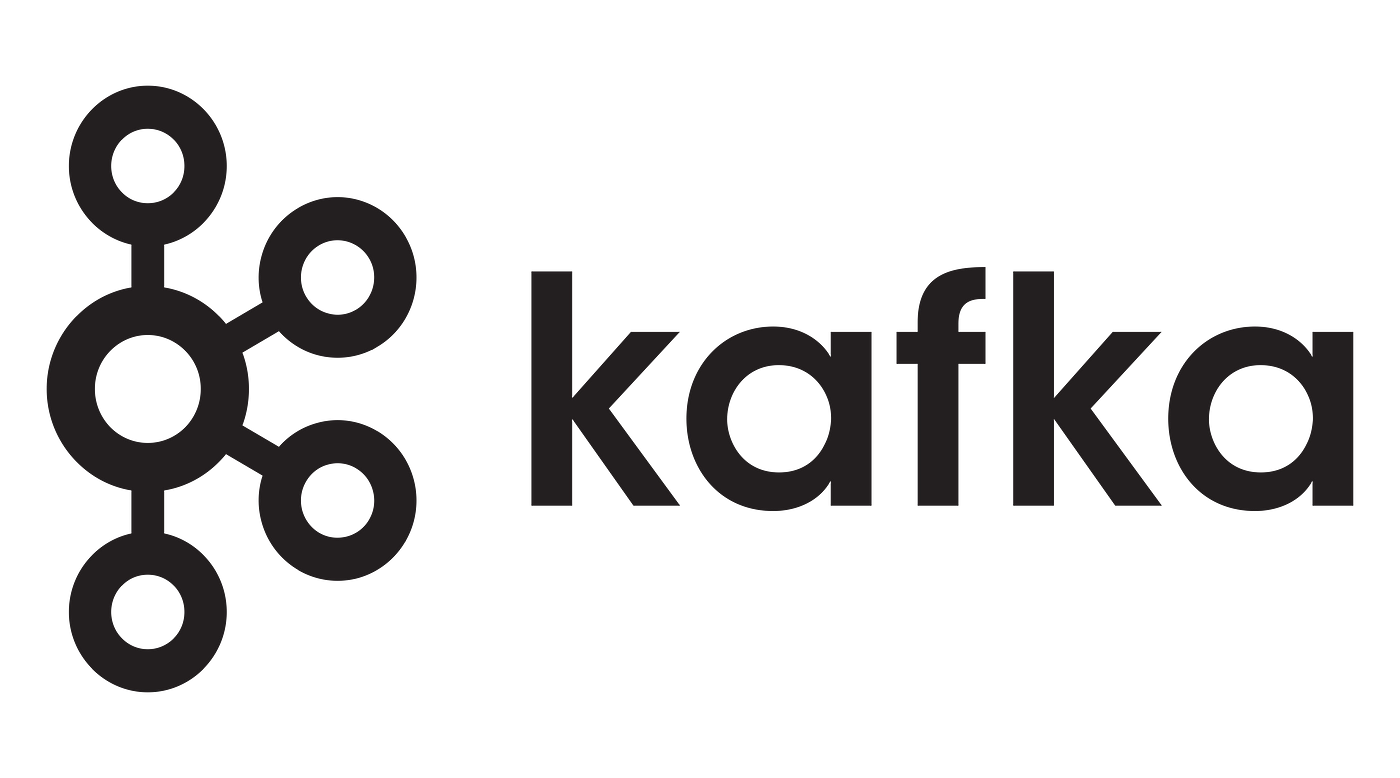

Kafka consente una comunicazione **asincrona** tra le componenti del progetto: Fluentd agisce come **producer**, inviando i dati a Kafka, mentre Spark agisce come **consumer**, prelevando i dati dai topic e processandoli in tempo reale.

Grazie al sistema di **persistenza** di Kafka, i dati restano memorizzati nei topic per un periodo configurabile, anche se sono stati già consumati.

# Data Processing: Spark

Quando un record contenente i parametri vitali di un paziente arriva a **Spark**, il dato viene arricchito con parametri derivati. Questo arricchimento consente una valutazione più approfondita dello stato clinico del paziente, migliorando sia l’interpretazione dei dati che il supporto alle decisioni mediche. In particolare, vengono calcolati:

- **Pulse Pressure** = Pressione Sistolica - Pressione Diastolica
- **BMI (Body Mass Index)** = Peso / (Altezza²)
- **MAP (Mean Arterial Pressure)** = Pressione Diastolica + (Pressione Sistolica - Pressione Diastolica) / 3

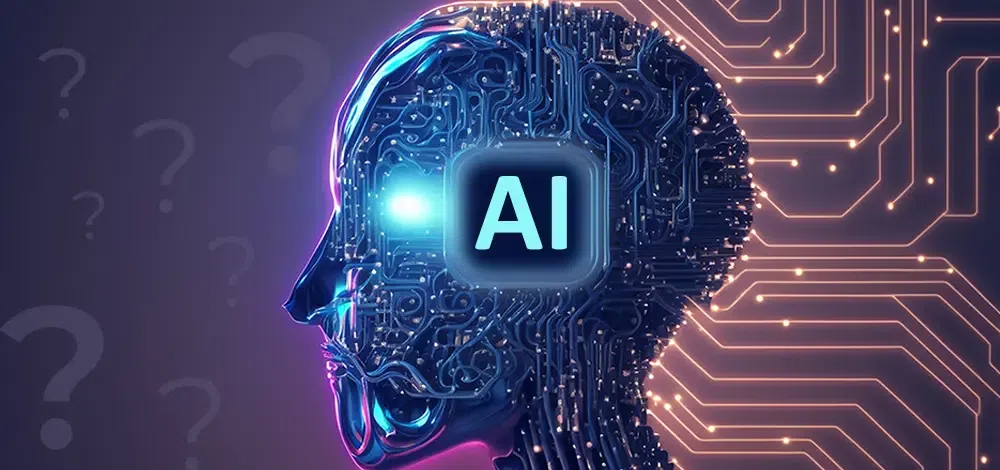

Dopo l’arricchimento, il record viene elaborato da un modello di machine learning, addestrato sul dataset **[Human Vital Signs](https://www.kaggle.com/datasets/nasirayub2/human-vital-sign-dataset/data)** di Kaggle.
Il modello analizza i parametri vitali e classifica il paziente in una delle seguenti categorie di rischio:
- **High Risk (Alto rischio)**
- **Low Risk (Basso rischio)**

Questo consente di **automatizzare la valutazione del rischio** in tempo reale e **superare i limiti delle soglie fisse**.

# Data Indexing: Elastic Search

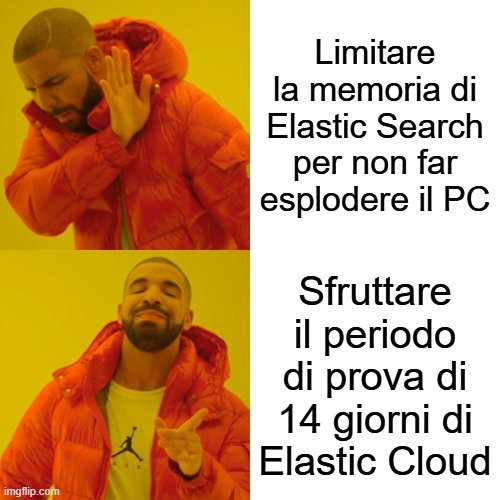

- **L'indicizzazione** consente di creare dei **riferimenti strutturati** ai **dati**, rendendo più veloce ed efficiente la **ricerca** e il **recupero delle informazioni**. È comunemente utilizzata nei **database** e nei **motori di ricerca**.  
- **Elasticsearch** è un motore di ricerca e analisi distribuito, scalabile e open-source, basato su Apache Lucene. 

# Data Visualization: Kibana

# Dati clinici
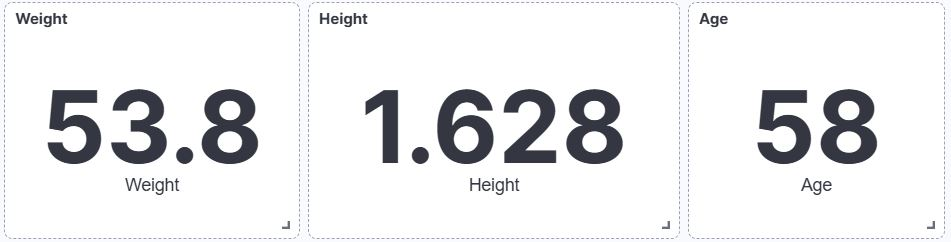



# Grafico a torta per il rischio predetto dall'AI
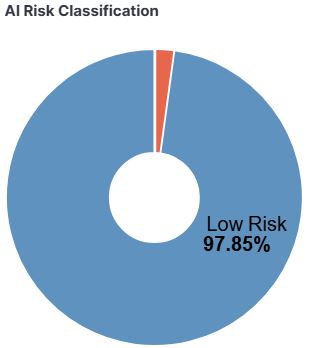

# Trend temporale di ciascun parametro vitale
Per ogni parametro vitale, è presente un grafico che mostra l'andamento nel tempo. Questa visualizzazione consente di identificare pattern, anomalie o tendenze che potrebbero indicare un deterioramento o un miglioramento delle condizioni del paziente.

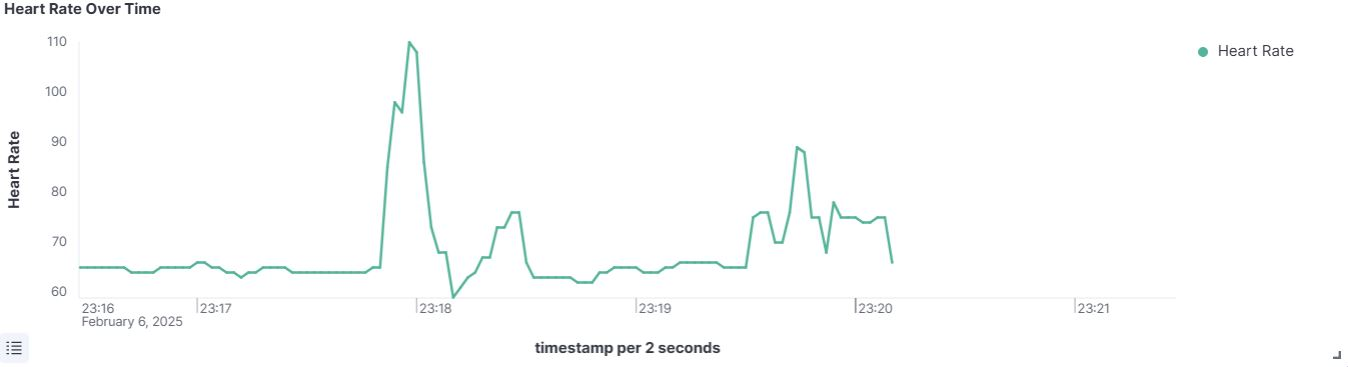

# Grafici Gauge

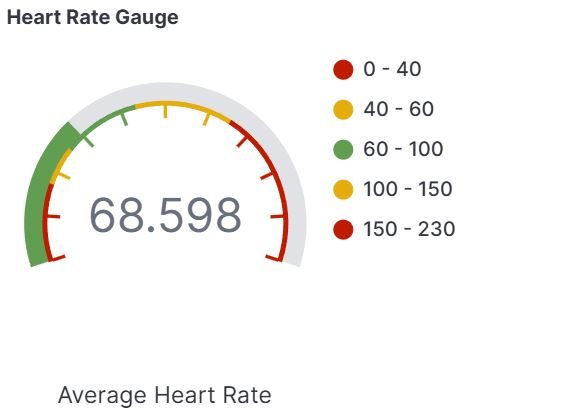

Ogni parametro ha un Grafico Gauge che mostra la media dei valori nell'intervallo di tempo selezionato (ad esempio, ultimi 5 o 10 minuti). Il gauge è dotato di un sistema a colori che rappresenta il livello di rischio:
- **Verde**: Valori nella norma
- **Giallo**: Valori al limite, necessaria attenzione
- **Rosso**: Valori critici, potenziale emergenza

# Considerazioni

L'integrazione dei due grafici visti in precedenza consente di ottenere un monitoraggio più efficace e dettagliato, riducendo il rischio di trascurare anomalie potenzialmente critiche.


- Il grafico gauge fornisce un'indicazione **immediata** del valore medio del parametro selezionato in un intervallo di tempo definito (es. ultimi 5 minuti). Questa rappresentazione consente di valutare **rapidamente** lo stato generale di salute del paziente, senza dover analizzare l'intera serie storica.

- Sebbene il valore medio fornito dal gauge sia utile, esso può **nascondere fluttuazioni significative**. Il grafico che mostra la variazione nel tempo del parametro consente di evidenziare eventuali **picchi** o **anomalie** che potrebbero una semplice media potrebbe **mascherare**.

# Grazie per l'attenzione!